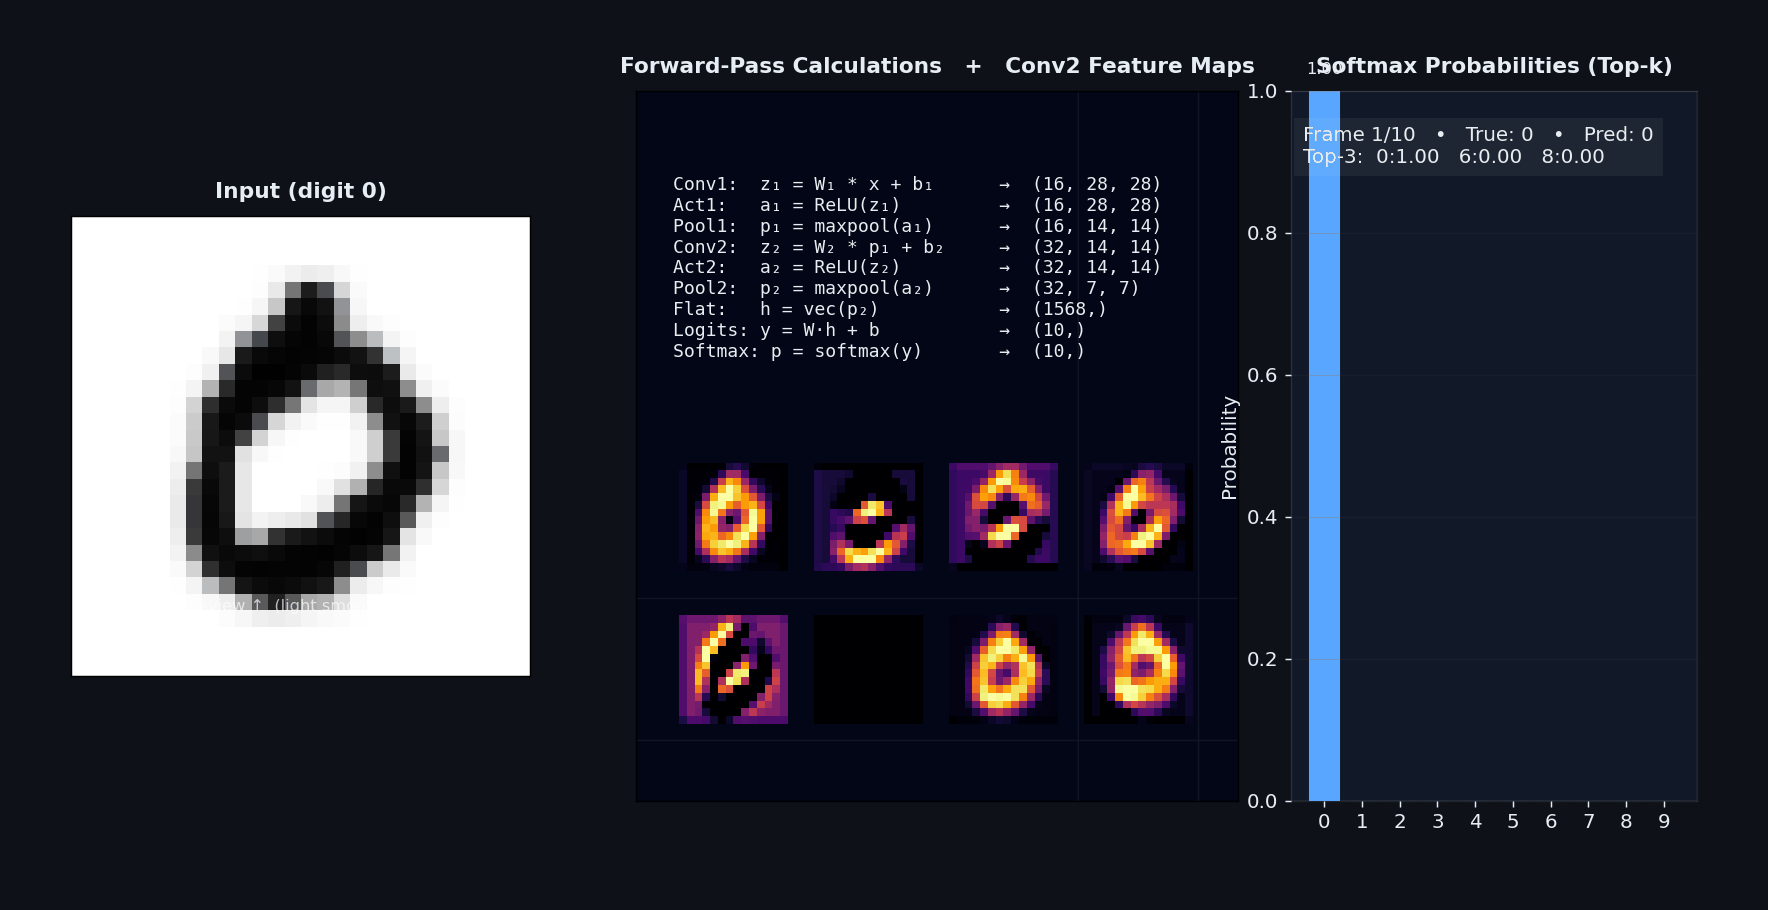

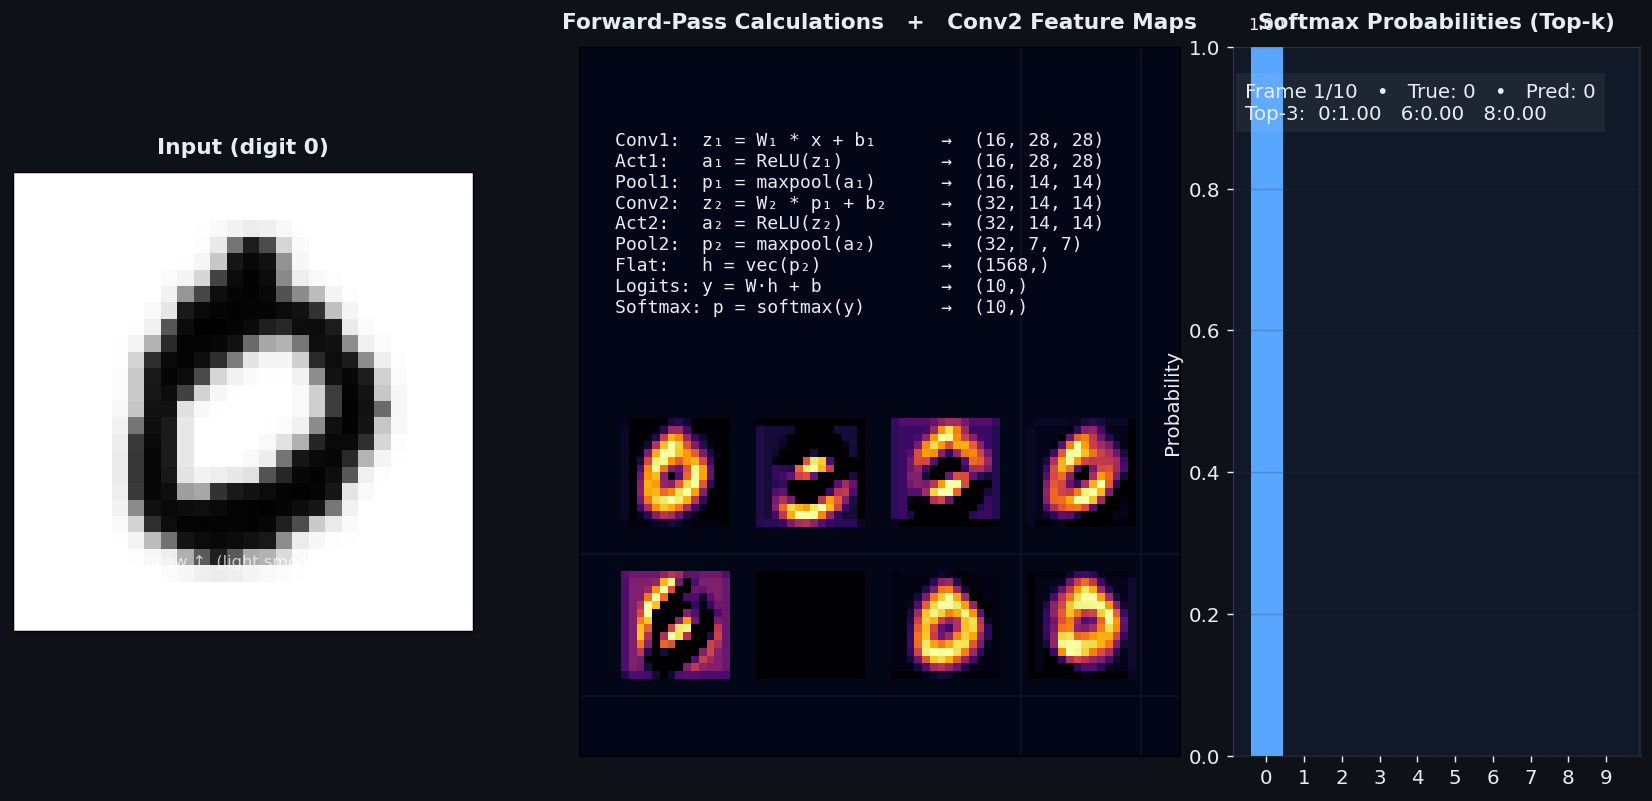

In [18]:
# ============================================
# CNN Forward-Pass Explainer (MNIST, 0–9 cycle) 
# ============================================

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import patches
from IPython.display import HTML, display, Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# ---------- Optional: image "cleaning" ----------
try:
    from skimage.filters import median
    from skimage.morphology import disk
    HAVE_SKI = True
except Exception:
    HAVE_SKI = False

THEME = "dark"   # "dark" or "light"
mpl.rcParams["animation.embed_limit"] = 40
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["font.size"] = 11

if THEME == "dark":
    BG, FG, GRID = "#0e1117", "#e6edf3", "#30363d"
    ACC, ACC_SOFT = "#58a6ff", "#1f6feb"
    CARD = "#111827"
    TILE = "#0b1220"
    CMAP_IMG, CMAP_FEAT = "gray_r", "inferno"
else:
    BG, FG, GRID = "#ffffff", "#0a0a0a", "#e6e6e6"
    ACC, ACC_SOFT = "#0b5fff", "#1f6feb"
    CARD = "#f7f7fb"
    TILE = "#f0f2f7"
    CMAP_IMG, CMAP_FEAT = "gray", "inferno"

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Data ----------
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=tfm)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)


rng = np.random.default_rng(0)
train_subset = Subset(train_ds, rng.choice(len(train_ds), 6000, replace=False))
test_subset  = Subset(test_ds,  rng.choice(len(test_ds), 1500, replace=False))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_subset,  batch_size=512, shuffle=False, num_workers=0)

# ---------- Model ----------
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, padding=1)   # -> (B,16,28,28)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)  # -> (B,32,14,14) after pool
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x, return_intermediates=False):
        z1 = self.c1(x); a1 = F.relu(z1); p1 = F.max_pool2d(a1, 2)   # (B,16,14,14)
        z2 = self.c2(p1); a2 = F.relu(z2); p2 = F.max_pool2d(a2, 2)  # (B,32,7,7)
        flat = p2.view(p2.size(0), -1)
        logits = self.fc(flat)
        probs  = F.softmax(logits, dim=1)
        if return_intermediates:
            return dict(z1=z1, a1=a1, p1=p1, z2=z2, a2=a2, p2=p2,
                        flat=flat, logits=logits, probs=probs)
        return probs

model = TinyCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# ---------- Quick train ----------
model.train()
for epoch in range(2):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()

model.eval()

# ---------- Guarantee one example per TRUE digit (0..9) ----------
full_test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False)
picked = {}
with torch.no_grad():
    for xb, yb in full_test_loader:
        for i in range(xb.size(0)):
            d_true = int(yb[i])
            if d_true not in picked:
                picked[d_true] = (xb[i:i+1].to(device), d_true)
                if len(picked) == 10:
                    break
        if len(picked) == 10:
            break

digits    = sorted(picked.keys())                # typically 0..9
samples   = [picked[d][0] for d in digits]
true_lbls = [picked[d][1] for d in digits]

# ---------- Optional cleaned image helper ----------
def clean_np(x28):
    if HAVE_SKI:
        return median(x28, disk(1))
    k = np.ones((3,3))/9.0
    xpad = np.pad(x28, 1, mode="edge")
    out = np.zeros_like(x28)
    for i in range(28):
        for j in range(28):
            out[i,j] = (xpad[i:i+3, j:j+3] * k).sum()
    return out

# ---------- Precompute intermediates ----------
with torch.no_grad():
    inter_all = [model(x, return_intermediates=True) for x in samples]
    probs_all = [it["probs"].squeeze().cpu().numpy() for it in inter_all]
    preds     = [int(p.argmax()) for p in probs_all]

# ---------- Which Conv2 channels to show ----------
sel_c2 = [0, 4, 8, 12, 16, 20, 24, 28]

# ---------- Figure ----------
fig = plt.figure(figsize=(13.6, 7.0), dpi=130, facecolor=BG)
fig.patch.set_facecolor(BG)

# Panels
ax_img  = fig.add_axes([0.04, 0.12, 0.26, 0.78], facecolor=BG)
ax_feat = fig.add_axes([0.36, 0.12, 0.34, 0.78], facecolor=BG)
ax_cls  = fig.add_axes([0.73, 0.12, 0.23, 0.78], facecolor=BG)

# Card backgrounds (rounded)
def add_card(ax, pad=(0.02, 0.02), fc=CARD, ec=(1,1,1,0.06)):
    rect = patches.FancyBboxPatch((pad[0], pad[1]), 1-pad[0]*2, 1-pad[1]*2,
                                  transform=ax.transAxes, boxstyle="round,pad=0.02,rounding_size=10",
                                  fc=fc, ec=ec, lw=1.0, zorder=-2)
    ax.add_patch(rect)

for ax in (ax_img, ax_feat, ax_cls):
    add_card(ax)

# ---- LEFT: image area ----
ax_img.set_title("Input", color=FG, pad=10, fontsize=12)
ax_img.set_xticks([]); ax_img.set_yticks([])
# Slight inner frame for the image itself
inner = patches.FancyBboxPatch((0.07, 0.10), 0.86, 0.80,
                               transform=ax_img.transAxes, boxstyle="round,pad=0.01,rounding_size=6",
                               fc=TILE, ec=(1,1,1,0.08), lw=1.0, zorder=-1)
ax_img.add_patch(inner)

# Show pixel art crisply
im0      = ax_img.imshow(np.zeros((28,28)), cmap=CMAP_IMG, vmin=0, vmax=1, interpolation="nearest")
im_clean = ax_img.imshow(np.zeros((28,28)), cmap=CMAP_IMG, vmin=0, vmax=1, alpha=0.0, interpolation="nearest")
txt_clean = ax_img.text(0.09, 0.14, "cleaned preview ↑  (light smoothing)",
                        transform=ax_img.transAxes, color=(1,1,1,0.7) if THEME=="dark" else (0,0,0,0.7),
                        fontsize=9)

# ---- MIDDLE: equations top + feature maps bottom ----
ax_feat.set_title("Forward-Pass Calculations   +   Conv2 Feature Maps", color=FG, pad=10, fontsize=12)
ax_feat.set_xticks([]); ax_feat.set_yticks([])

# Equations "card" at top
eq_bg = patches.FancyBboxPatch((0.04, 0.58), 0.92, 0.32,
                               transform=ax_feat.transAxes, boxstyle="round,pad=0.02,rounding_size=8",
                               fc=TILE, ec=(1,1,1,0.08), lw=1.0)
ax_feat.add_patch(eq_bg)
calc_box = ax_feat.text(0.06, 0.88,
    "Conv1:  z₁ = W₁ * x + b₁      →  (16, 28, 28)\n"
    "Act1:   a₁ = ReLU(z₁)         →  (16, 28, 28)\n"
    "Pool1:  p₁ = maxpool(a₁)      →  (16, 14, 14)\n"
    "Conv2:  z₂ = W₂ * p₁ + b₂     →  (32, 14, 14)\n"
    "Act2:   a₂ = ReLU(z₂)         →  (32, 14, 14)\n"
    "Pool2:  p₂ = maxpool(a₂)      →  (32, 7, 7)\n"
    "Flat:   h = vec(p₂)           →  (1568,)\n"
    "Logits: y = W·h + b           →  (10,)\n"
    "Softmax: p = softmax(y)       →  (10,)",
    transform=ax_feat.transAxes, va="top", ha="left", color=FG, family="monospace", fontsize=10)

# Feature-map grid "card"
fm_bg = patches.FancyBboxPatch((0.04, 0.06), 0.92, 0.46,
                               transform=ax_feat.transAxes, boxstyle="round,pad=0.02,rounding_size=8",
                               fc=TILE, ec=(1,1,1,0.08), lw=1.0)
ax_feat.add_patch(fm_bg)

# Create mini-tiles for Conv2 maps
axes_c2, ims_c2, norms_c2 = [], [], []
tile_positions = []
for r in range(2):
    for c in range(4):
        # normalized position inside the grid card
        x0 = 0.07 + c*0.225
        y0 = 0.095 + (1-r)*0.215
        w, h = 0.18, 0.18
        # tile card
        tile = patches.FancyBboxPatch((x0, y0), w, h,
                                      transform=ax_feat.transAxes, boxstyle="round,pad=0.01,rounding_size=6",
                                      fc="#020617" if THEME=="dark" else "#ffffff", ec=(1,1,1,0.06), lw=0.8)
        ax_feat.add_patch(tile)
        # axes for the image itself
        ax_sub = fig.add_axes([
            ax_feat.get_position().x0 + x0*(ax_feat.get_position().width),
            ax_feat.get_position().y0 + y0*(ax_feat.get_position().height),
            w*(ax_feat.get_position().width),
            h*(ax_feat.get_position().height)
        ], facecolor="none")
        for s in ax_sub.spines.values(): s.set_visible(False)
        ax_sub.set_xticks([]); ax_sub.set_yticks([])
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
        img = ax_sub.imshow(np.zeros((14,14)), cmap=CMAP_FEAT, norm=norm, interpolation="nearest")
        axes_c2.append(ax_sub); ims_c2.append(img); norms_c2.append(norm)

# ---- RIGHT: softmax bars ----
ax_cls.set_title("Softmax Probabilities (Top-k)", color=FG, pad=10, fontsize=12)
classes = [str(i) for i in range(10)]
bars = ax_cls.bar(classes, np.zeros(10), color=ACC_SOFT, edgecolor=(1,1,1,0.10), linewidth=0.6)
ax_cls.set_ylim(0, 1.0)
ax_cls.grid(axis="y", alpha=0.25, color=GRID)
ax_cls.set_ylabel("Probability", color=FG)
ax_cls.tick_params(colors=FG)
for s in ax_cls.spines.values(): s.set_edgecolor((1,1,1,0.08))

# value labels
val_texts = [ax_cls.text(i, 0.01, "", ha="center", va="bottom", color=FG, fontsize=9) for i in range(10)]

topk_txt = ax_cls.text(0.03, 0.95, "", transform=ax_cls.transAxes, va="top", color=FG,
                       bbox=dict(facecolor=(1,1,1,0.06) if THEME=="dark" else (0,0,0,0.06),
                                 edgecolor="none", pad=5))

# ---------- Animation ----------
frames = list(range(len(digits)))

def update(fi):
    # Left: image + cleaned overlay
    x = samples[fi].cpu().squeeze().numpy()
    im0.set_data(x)
    im_clean.set_data(clean_np(x)); im_clean.set_alpha(0.28)
    ax_img.set_title(f"Input (digit {true_lbls[fi]})", color=FG, pad=10, fontsize=12)

    # Middle: Conv2 maps (dynamic contrast + gamma)
    a2 = inter_all[fi]["a2"].squeeze().cpu().numpy()  # (32, 14, 14)
    for img_, norm_, ch in zip(ims_c2, norms_c2, sel_c2):
        arr = np.clip(a2[ch], 0, None)
        arr = np.power(arr, 0.75)                # gamma for pop
        lo, hi = np.percentile(arr, (2, 98))
        if not np.isfinite(lo) or hi <= lo:
            lo, hi = float(arr.min()), float(arr.max() + 1e-6)
        img_.set_data(arr)
        norm_.vmin = lo; norm_.vmax = hi

    # Right: bars + labels
    pr = probs_all[fi]; y_pred = preds[fi]; y_true = true_lbls[fi]
    for i, (b, t) in enumerate(zip(bars, val_texts)):
        b.set_height(pr[i])
        b.set_color(ACC if i == y_pred else ACC_SOFT)
        t.set_text(f"{pr[i]:.2f}" if pr[i] > 0.02 else "")
        t.set_y(pr[i] + 0.02)
    top = pr.argsort()[::-1][:3]
    topk_txt.set_text(
        f"Frame {fi+1}/{len(frames)}   •   True: {y_true}   •   Pred: {y_pred}\n"
        f"Top-3:  {top[0]}:{pr[top[0]]:.2f}   {top[1]}:{pr[top[1]]:.2f}   {top[2]}:{pr[top[2]]:.2f}"
    )
    return ()

ani = FuncAnimation(fig, update, frames=frames, interval=800, blit=False, repeat=False)

display(HTML(ani.to_jshtml()))

# ---------- Save a crisp, compact GIF (no ffmpeg required) ----------
gif_path = "nn.gif"
ani.save(gif_path, writer=PillowWriter(fps=1))
display(Image(filename=gif_path))
